# VAR 2020

Importando bibliotecas; carregando e proparando os dados.
Para essa ferramenta, os dados estão NORMALIZADOS  no intervalo [-1, 1].
Com os valores originais, ela não funcionou adequadamente.

<AxesSubplot:xlabel='data'>

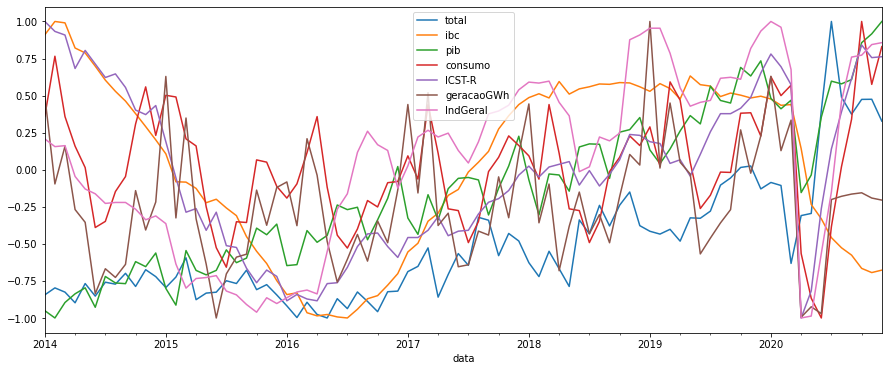

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
import math as mt
import matplotlib as mpl 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

colunas = ['total','ibc', 'pib','consumo', 'ICST-R', 'geracaoGWh', 'IndGeral']

def minmax_norm1(df): # Normaliza de -1 a +1.
    return 2*(df-df.min())/(df.max()-df.min()) - 1

df = pd.read_csv('dadosRonaldo.csv')
df.head()
df = df.set_index('data')
df.index = pd.to_datetime(df.index)

df_minmax_norm1 = minmax_norm1(df)

data = df_minmax_norm1[colunas]

data.plot(figsize = (15,6))

Antes de aplicar o VAR, devemos nos certificar que as séries temporais são estacionárias. 
Séries não-estacionárias não mantêm a média e a variância constantes na passagem do tempo.
O teste Augmented Dickey-Fuller test (ADF) pode ser aplicado, usando o AIC.

In [20]:
from statsmodels.tsa.stattools import adfuller
print('#'*50)
print('### Augmented Dickey-Fuller test (ADF Test)')
print('#'*50)
for variavel in colunas:
    adfuller_test = adfuller(data[variavel], autolag= "AIC")
    print('Variável: ', variavel)
    print("ADF test statistic: {}".format(adfuller_test[0]))
    print("p-value: {}".format(adfuller_test[1]))
    print('\n')
print('#'*50)

##################################################
### Augmented Dickey-Fuller test (ADF Test)
##################################################
Variável:  total
ADF test statistic: 1.7878449662330245
p-value: 0.9983246023579447


Variável:  ibc
ADF test statistic: -1.4999942744075683
p-value: 0.5335141712770834


Variável:  pib
ADF test statistic: -0.09737582955985712
p-value: 0.9496992845645541


Variável:  consumo
ADF test statistic: -1.9706906766167192
p-value: 0.2995701932408904


Variável:  ICST-R
ADF test statistic: -2.445095353230605
p-value: 0.1294108405550845


Variável:  geracaoGWh
ADF test statistic: -1.3089423669168658
p-value: 0.6250713042411298


Variável:  IndGeral
ADF test statistic: -2.600443155611724
p-value: 0.09290571077275583


##################################################


Como o p-valor ainda é alto, não podemos rejeitar a hipótese nula: a séries temporais não são estacionárias.

Podemos diferenciar as séries temporais e voltar a conferir suas estacionariedades.

In [21]:
data_d = data.diff().dropna()

print('#'*50)
print('### Augmented Dickey-Fuller test (ADF Test)')
print('#'*50)
for variavel in ['ibc', 'pib','consumo', 'ICST-R', 'geracaoGWh', 'IndGeral']:
    adfuller_test = adfuller(data_d[variavel], autolag= "AIC")
    print('Variável: ', variavel)
    print("ADF test statistic: {}".format(adfuller_test[0]))
    print("p-value: {}".format(adfuller_test[1]))
    print('\n')
print('#'*50)

##################################################
### Augmented Dickey-Fuller test (ADF Test)
##################################################
Variável:  ibc
ADF test statistic: -1.6090165906691427
p-value: 0.4790627605172163


Variável:  pib
ADF test statistic: -8.174309377003908
p-value: 8.457624122591302e-13


Variável:  consumo
ADF test statistic: -3.633430653441142
p-value: 0.005153145093829432


Variável:  ICST-R
ADF test statistic: -7.836644680016315
p-value: 6.090088432331259e-12


Variável:  geracaoGWh
ADF test statistic: -7.0343027264276765
p-value: 6.07192488225717e-10


Variável:  IndGeral
ADF test statistic: -5.9302669725746995
p-value: 2.389817615395194e-07


##################################################


O p-valor tornaram-se bastante pequenos.
Apenas o 'ibc' segue 'alto', mas decidimos seguir o processo de previsão. 

Organizando os conjuntos de treino (2014->2019) e teste (2020). 

In [23]:
train = data_d.iloc[:-12,:]
test = data_d.iloc[-12:,:]

In [13]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59 entries, 2014-02-01 to 2018-12-01
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total       59 non-null     float64
 1   ibc         59 non-null     float64
 2   pib         59 non-null     float64
 3   consumo     59 non-null     float64
 4   ICST-R      59 non-null     float64
 5   geracaoGWh  59 non-null     float64
 6   IndGeral    59 non-null     float64
dtypes: float64(7)
memory usage: 3.7 KB


,total,ibc,pib,consumo,ICST-R,geracaoGWh,IndGeral
data,,,,,,,
2014-02-01,0.046986,0.089517,-0.049344,0.404142,-0.067073,-0.591563,-0.051948
2014-03-01,-0.028634,-0.009423,0.104428,-0.407181,-0.024390,0.254779,0.006494
2014-04-01,-0.071876,-0.169611,0.058472,-0.199338,-0.225610,-0.427510,-0.207792
2014-05-01,0.129791,-0.032980,0.040525,-0.144553,0.121951,-0.086156,-0.084416
2014-06-01,-0.084801,-0.089517,-0.131237,-0.404229,-0.091463,-0.481662,-0.032468


In [24]:
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2020-01-01 to 2020-12-01
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total       12 non-null     float64
 1   ibc         12 non-null     float64
 2   pib         12 non-null     float64
 3   consumo     12 non-null     float64
 4   ICST-R      12 non-null     float64
 5   geracaoGWh  12 non-null     float64
 6   IndGeral    12 non-null     float64
dtypes: float64(7)
memory usage: 768.0 bytes


,total,ibc,pib,consumo,ICST-R,geracaoGWh,IndGeral
data,,,,,,,
2020-01-01,0.043391,-0.018846,-0.253455,0.400137,0.128049,0.401921,0.064935
2020-02-01,-0.020337,-0.042403,-0.069821,-0.127558,-0.085366,-0.501782,-0.038961
2020-03-01,-0.525628,0.004711,0.057876,0.070370,-0.121951,0.206006,-0.285714
2020-04-01,0.322531,-0.296820,-0.623057,-1.135377,-1.573171,-1.329308,-1.675325
2020-05-01,0.014541,-0.376914,0.118610,-0.301729,0.182927,0.070355,0.012987


Cria o modelo VAR e faz a análise do AIC.

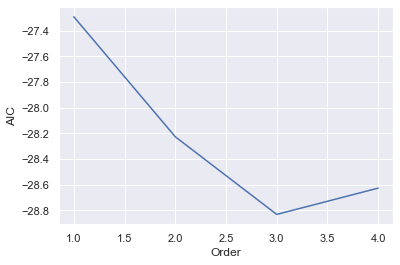

In [25]:
forecasting_model = VAR(train, freq = 'MS')
results_aic = []

for p in range(1,5):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)
  

sns.set()
plt.plot(list(np.arange(1,5,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

Podemos concluir que 3 é o melhor lag.

Ajuste do modeo VAR e previsões.

In [26]:
results = forecasting_model.fit(3)
results.summary()

train.values

laaged_values = train.values[-3:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=12), 
                        index = test.index, 
                        columns= colunas)
forecast

,total,ibc,pib,consumo,ICST-R,geracaoGWh,IndGeral
data,,,,,,,
2020-01-01,0.048146,-0.069942,-0.128133,0.001164,-0.026581,0.157024,0.071990
2020-02-01,-0.017522,-0.019371,0.025561,-0.017752,-0.041420,-0.262831,-0.066979
2020-03-01,0.072621,-0.006806,0.136839,0.122998,-0.027594,0.338335,-0.029077
2020-04-01,-0.030308,-0.024240,-0.020734,-0.029039,-0.001045,-0.254112,0.033875
2020-05-01,0.022528,-0.007259,0.043042,-0.026533,-0.011652,0.186675,0.025605
2020-06-01,-0.005287,-0.024600,-0.039713,0.007001,0.012284,-0.033529,0.020903
2020-07-01,0.009928,-0.010976,0.038952,0.003932,-0.037264,0.004337,0.001350
2020-08-01,0.011487,-0.014714,0.034211,0.061973,0.002401,0.020820,0.016473
2020-09-01,-0.002930,-0.010051,0.035993,-0.041720,-0.010155,-0.041650,-0.000805


Apresentação dos resultados normalizados.

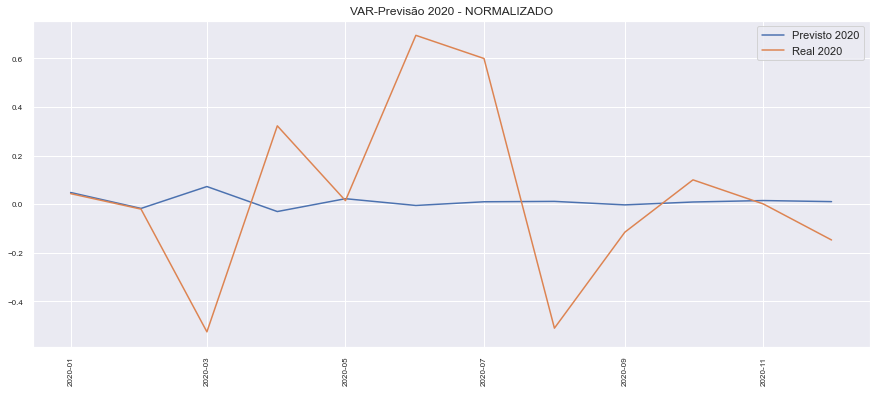

O valor do rmse para  total :  0.36961705468610406
O valor do rmse para  ibc :  0.14274821571563803
O valor do rmse para  pib :  0.24009709397968418
O valor do rmse para  consumo :  0.4816454763249438
O valor do rmse para  ICST-R :  0.5169103655844732
O valor do rmse para  geracaoGWh :  0.39836627003456354
O valor do rmse para  IndGeral :  0.5603328483433915


In [27]:
x = forecast.copy()
x.reset_index(inplace=True)
x = x['data']
y1 = forecast['total']
y2 = test['total']

plt.figure(figsize=(15,6))
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
plt.title('VAR-Previsão 2020 - NORMALIZADO')
plt.xticks(rotation=90)
plt.plot(x,y1,label="Previsto 2020")
plt.plot(x,y2,label="Real 2020")
plt.legend()
plt.show()

#Calcula o rmse de cada variável.
for i in colunas:
    print('O valor do rmse para ', i, ': ', mt.sqrt(mean_squared_error(forecast[i], test[i])))

Retira a normalização dos dados e apresenta os dados.
Conforme esperado, o aspecto das curvas é o mesmo.
O valor do rmse é ajsutado às escalas originais das variáveis usadas.

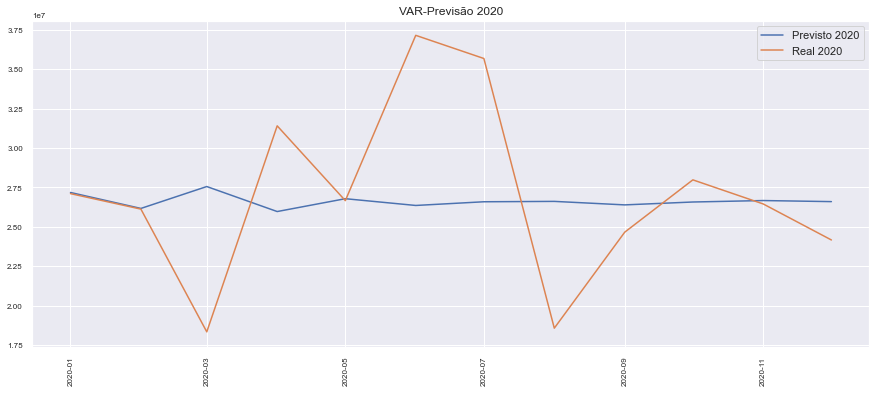

O valor do rmse para  total :  5697143.109940757
O valor do rmse para  ibc :  0.6059661757128836
O valor do rmse para  pib :  27132.54425566989
O valor do rmse para  consumo :  1637173.2784503547
O valor do rmse para  ICST-R :  8.477329995585356
O valor do rmse para  geracaoGWh :  2415.0145467468665
O valor do rmse para  IndGeral :  8.629125864488229


In [28]:
previsao_norm = forecast.copy()
previsao_orig = forecast.copy()
dados_orig = df[colunas]

for i in colunas:
    minimo = dados_orig[i].min()
    maximo = dados_orig[i].max()
    for j in range(0, len(previsao_norm)):
        previsao_orig[i][j] = (previsao_norm[i][j]+1)*(maximo - minimo)/2 + minimo

test_norm = test.copy()
test_orig = test.copy()
dados_orig = df[colunas]

for i in colunas:
    minimo = dados_orig[i].min()
    maximo = dados_orig[i].max()
    for j in range(0, len(previsao_norm)):
        test_orig[i][j] = (test_norm[i][j]+1)*(maximo - minimo)/2 + minimo


x = previsao_orig.copy()
x.reset_index(inplace=True)
x = x['data']
y1 = previsao_orig['total']
y2 = test_orig['total']

plt.figure(figsize=(15,6))
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
plt.title('VAR-Previsão 2020')
plt.xticks(rotation=90)
plt.plot(x,y1,label="Previsto 2020")
plt.plot(x,y2,label="Real 2020")
plt.legend()
plt.show()

#Calcula o rmse de cada variável.
for i in colunas:
    print('O valor do rmse para ', i, ': ', mt.sqrt(mean_squared_error(previsao_orig[i], test_orig[i])))